In [1]:
from my_model import *
from my_data import *
from my_plot import *

In [2]:
# 1. Set a global seed.
SEED = 1234  

# 2. OS Level: Guaranteeing that Python hashes are also reproducible  
os.environ['PYTHONHASHSEED'] = str(SEED)  

# 3. Make the underlying ops of TF use deterministic implementations as much as possible (2.x). 
os.environ['TF_DETERMINISTIC_OPS']    = '1'  
os.environ['TF_CUDNN_DETERMINISM']    = '1'  

# 4. Python comes with random built-in.
random.seed(SEED)  
# 5. NumPy  
np.random.seed(SEED)  
# 6. TensorFlow  
tf.random.set_seed(SEED) 

In [3]:
#Read data
data = prepare_training_data("Equil/equil_extracted_train",
network_pattern_mid="network_output", ls_pattern_mid=".linkstats_output")  
data_val = prepare_training_data("Equil/equil_extracted_val",
network_pattern_mid="network_output", ls_pattern_mid=".linkstats_output")  

#Data Normalization
info = get_data_info(data)
data_nor =  min_max_nor_data(data,info)
data_val_nor = min_max_nor_data(data_val,info)
ds_nor = build_dataset(data_nor)
ds_val_nor = build_dataset(data_val_nor)
train_dataset_nor = ds_nor
batch_size = 32
train_ds_batched_nor = train_dataset_nor.shuffle(buffer_size=3,seed=SEED).batch(batch_size=batch_size).repeat()

In [4]:
model_input_graph_spec, label_spec = train_dataset_nor.element_spec
del label_spec  # Delete unused tag specifications

# Build model
model_nor = build_regression_model(
    graph_tensor_spec=model_input_graph_spec,
    node_dim=128,
    edge_dim=32,
    message_dim=128,
    next_state_dim=128,
    output_dim=25,  
    num_message_passing=3,
    l2_regularization=5e-5,
    dropout_rate=0.01, )

# Compile model
model_nor.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Print model structure
model_nor.summary()


f =  KerasTensor(type_spec=TensorSpec(shape=(23, 33), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents (InstanceMethod)                                          
                                                                 
 map_features (MapFeatures)  ()                        37440     
                                                                 
 graph_update (GraphUpdate)  ()                        65792     
                                                                 
 graph_update_1 (GraphUpdat  ()                        65792     
 e)                                  

In [5]:
# Train model
history_nor = model_nor.fit(train_ds_batched_nor, steps_per_epoch=10,epochs=150,validation_data=ds_val_nor)

Epoch 1/150

10/10 [==============================] - 4s 85ms/step - loss: 0.0932 - mean_absolute_error: 0.0505 - root_mean_squared_error: 0.2098 - val_loss: 0.0572 - val_mean_absolute_error: 0.0348 - val_root_mean_squared_error: 0.1041
Epoch 2/150
10/10 [==============================] - 1s 47ms/step - loss: 0.0541 - mean_absolute_error: 0.0365 - root_mean_squared_error: 0.0983 - val_loss: 0.0495 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0875
Epoch 3/150
10/10 [==============================] - 0s 44ms/step - loss: 0.0463 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0789 - val_loss: 0.0416 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0615
Epoch 4/150
10/10 [==============================] - 0s 48ms/step - loss: 0.0394 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0551 - val_loss: 0.0365 - val_mean_absolute_error: 0.0227 - val_root_mean_squared_error: 0.0457
Epoch 5/150
10/10 [==============================] - 1s

In [ ]:
#Save model
tf.saved_model.save(model_nor, "Equil/my_saved_model_equil") 

with open("Equil/train_history_equil.json", "w") as f:  
    json.dump(history_nor.history, f)

c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be impor

INFO:tensorflow:Assets written to: Equil/my_saved_model_equil\assets


INFO:tensorflow:Assets written to: Equil/my_saved_model_equil\assets


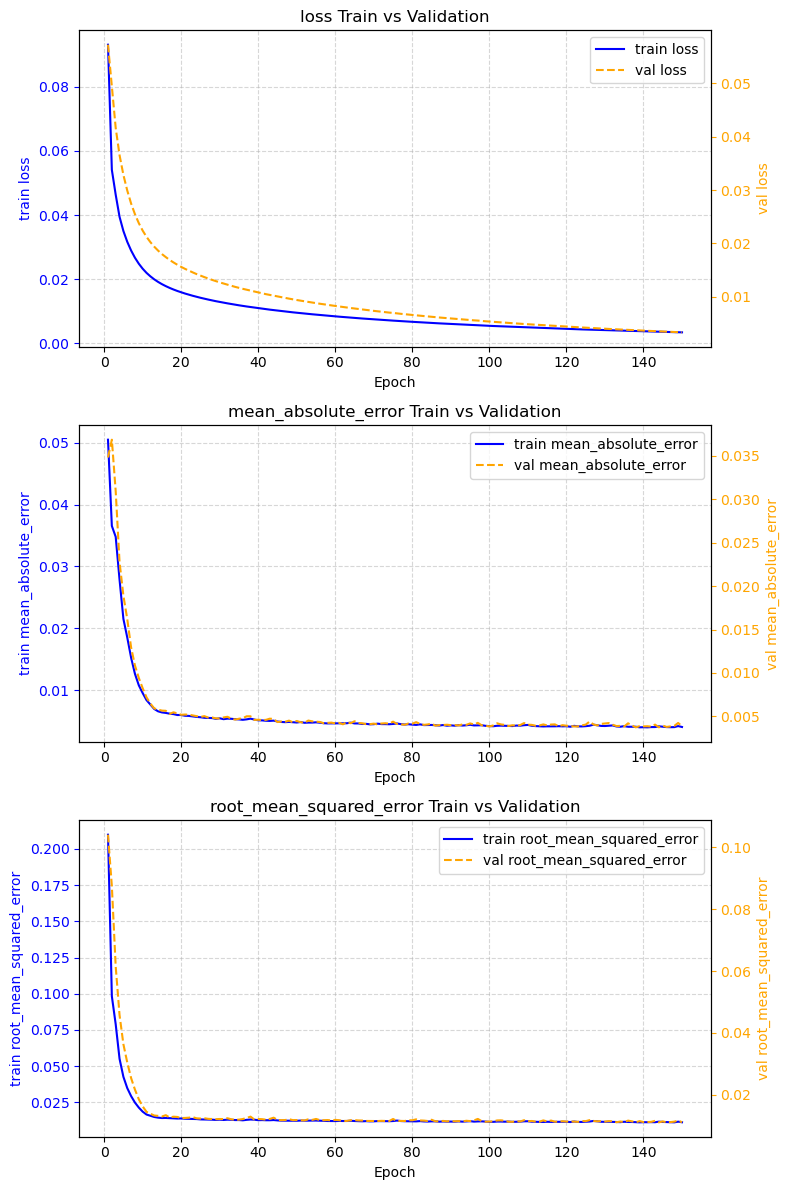

In [7]:
history_plot = history_nor
metrics = [m for m in history_plot.history if not m.startswith("val_")]  
n = len(metrics)  

fig, axes = plt.subplots(n, 1, figsize=(8, 4 * n), squeeze=False)  
for i, metric in enumerate(metrics):  
    val_metric = f"val_{metric}"  
    if val_metric not in history_plot.history:  
        continue  

    epochs = range(1, len(history_plot.history[metric]) + 1)  
    ax1 = axes[i, 0]  
    ax2 = ax1.twinx()  

    # train  
    ax1.plot(epochs, history_plot.history[metric],  
             color='blue',  label=f"train {metric}")  
    ax1.set_ylabel(f"train {metric}", color='blue')  
    ax1.tick_params(axis='y', colors='blue')  

    # val  
    ax2.plot(epochs, history_plot.history[val_metric],  
             color='orange',  label=f"val {metric}",linestyle="--")  
    ax2.set_ylabel(f"val {metric}", color='orange')  
    ax2.tick_params(axis='y', colors='orange')  

     
    ax1.set_xlabel("Epoch")  
    ax1.grid(True, linestyle="--", alpha=0.5)  
    lines = ax1.get_lines() + ax2.get_lines()  
    labels = [l.get_label() for l in lines]  
    ax1.legend(lines, labels, loc="best")  
    ax1.set_title(f"{metric} Train vs Validation")  

plt.tight_layout()  
plt.show()